# Thick Sample Ptychography Reconstruction Tutorial 2D

This tutorial demonstrates how to use `thick_ptycho` to Reconstruction a problem with multiple probes via PWE and Multislice.


### 1. Import Libraries: Sample Space and Forward Model


In [1]:
import os
from thick_ptycho.reconstruction.ms_reconstructor import ReconstructorMS
from thick_ptycho.reconstruction.pwe_reconstructor import ReconstructorPWE

from thick_ptycho.simulation.config import SimulationConfig, ProbeConfig
from thick_ptycho.simulation.ptycho_probe import create_ptycho_probes
from thick_ptycho.simulation.scan_frame import Limits
from thick_ptycho.simulation.simulation_space import create_simulation_space

import time
import numpy as np

from scipy.ndimage import zoom

from utils import plot_data

PETSc4Py is not installed. PWEPetscFullPinTSolver will not work without it.


In [2]:
# File path
npz_file_path = os.path.join("./results", "simulated_data.npz")

# Load the file. MUST use allow_pickle=True since the config was pickled.
loaded_data = np.load(npz_file_path, allow_pickle=True)

# Accessing the contents:

# 1. Load the NumPy arrays directly
intensity = loaded_data["intensity"]
exit_waves = loaded_data["exit_waves"]
ref_index = loaded_data["ref_index"]

# 2. Load the sim_config.
loaded_sim_config = loaded_data["sim_config"].item()

print("Successfully loaded arrays and config from simulated_data.npz.")

Successfully loaded arrays and config from simulated_data.npz.


In [ ]:
# Reduce Stepsize px
step_size_px = 20
points_per_wavelength = 2

print(f"Reduce Stepsize px: {loaded_sim_config['step_size_px']} -> {step_size_px}")
print(
    f"Points per wavelength: {loaded_sim_config['points_per_wavelength']} -> {points_per_wavelength}"
)
spatial_limits = Limits(
    x=loaded_sim_config["spatial_limits"]["x"],  # Sample width
    z=loaded_sim_config["spatial_limits"]["z"],  # Sample thickness
    units=loaded_sim_config["spatial_limits"]["units"],
)
probe_config = ProbeConfig(
    type=loaded_sim_config["probe_config"]["type"],
    wave_length=loaded_sim_config["probe_config"][
        "wave_length"
    ],  # meters (0.635 μm). Visible light
    diameter=loaded_sim_config["probe_config"]["diameter"],  # [m]
    focus=loaded_sim_config["probe_config"]["focus"],  # focal length [m]
)
sim_config = SimulationConfig(
    probe_config=probe_config,
    # Spatial discretization
    scan_points=loaded_sim_config["scan_points"],
    step_size_px=step_size_px,
    pad_factor=loaded_sim_config["pad_factor"],
    solve_reduced_domain=loaded_sim_config["solve_reduced_domain"],
    points_per_wavelength=points_per_wavelength,
    spatial_limits=spatial_limits,
    # Refractive index or Transmission Function Constant Surrounding Medium
    medium=loaded_sim_config["medium"],  # 1.0 for free space
    # Logging and results
    results_dir=loaded_sim_config["results_dir"],
    use_logging=loaded_sim_config["use_logging"],
)
simulation_space = create_simulation_space(sim_config)
simulation_space.summarize()

ptycho_probes = create_ptycho_probes(simulation_space)

2025-12-12 14:53:24,774 - INFO - === Scan Summary ===
2025-12-12 14:53:24,776 - INFO -   Sample space (x-range): 1.500e-04 m
2025-12-12 14:53:24,777 - INFO -   Sample space (z-range): 4.000e-05 m
2025-12-12 14:53:24,780 - INFO -   Sample Pixels:          3001 px
2025-12-12 14:53:24,783 - INFO -   Step size:              20 px
2025-12-12 14:53:24,785 - INFO -   Number of scan points:  60
2025-12-12 14:53:24,789 - INFO -   Steps in z:             62
2025-12-12 14:53:24,791 - INFO -   Probe diameter:         1.000e-05 m
2025-12-12 14:53:24,793 - INFO -   Probe Pixels:           200 px
2025-12-12 14:53:24,795 - INFO -   Max Overlap:            9.000e-06 m
2025-12-12 14:53:24,797 - INFO -   Percentage Overlap:     90.00%



Reduce Stepsize px: 50 -> 20
Points per wavelength: 16 -> 1


Original intensity shape: (60, 7501)
Coarse exit waves shape: (60, 3001)
Coarse intensity shape: (60, 3001)


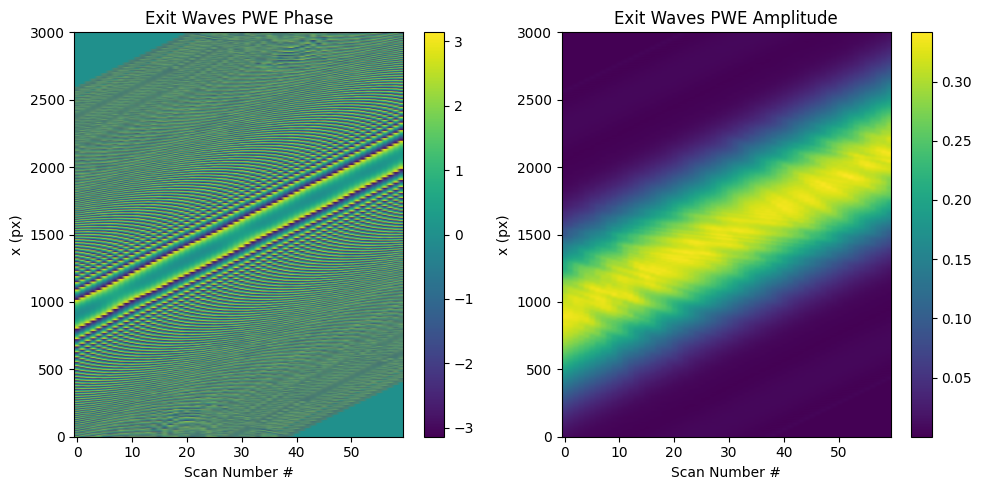

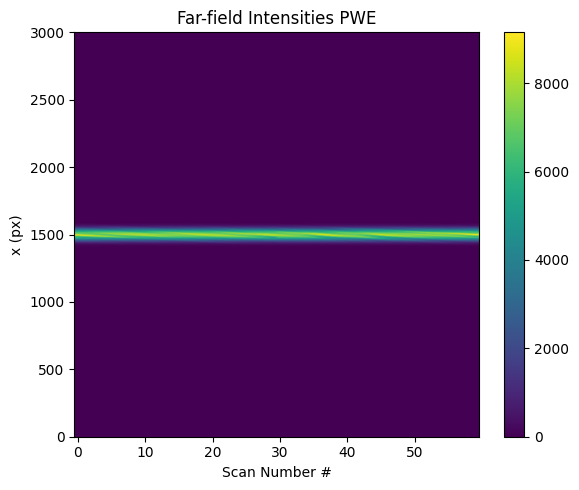

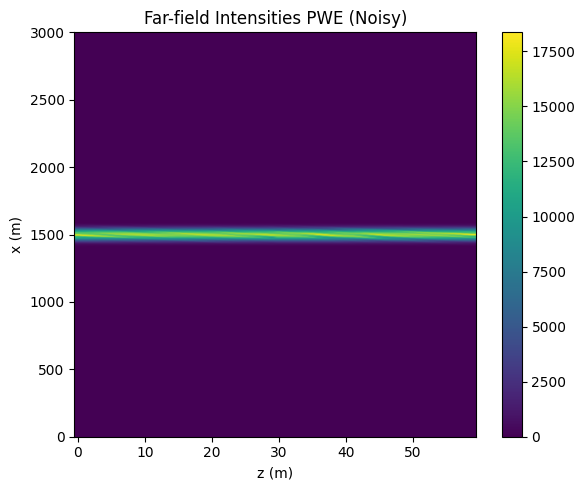

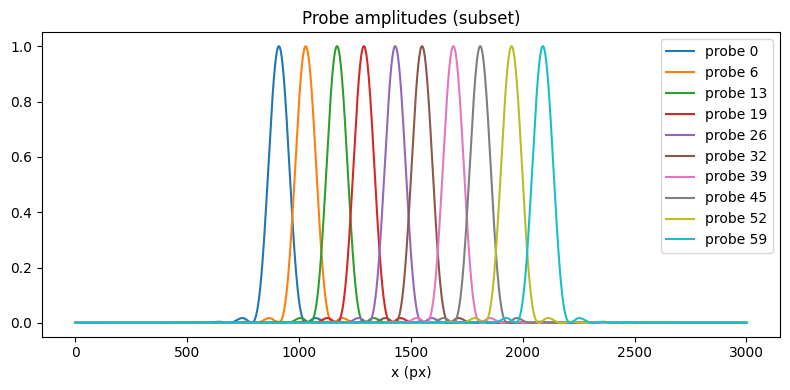

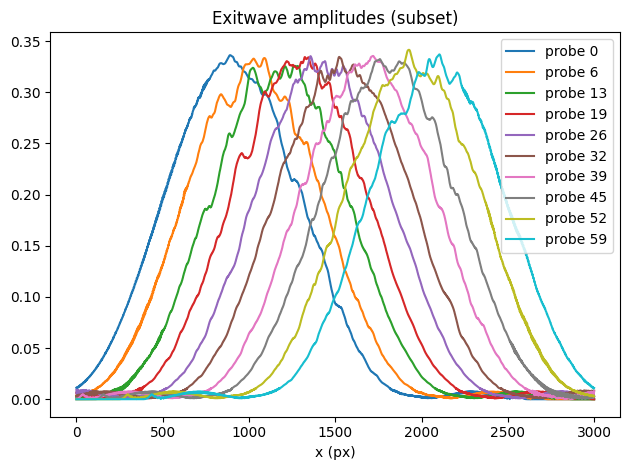

In [4]:
original_shape = intensity.shape
target_shape = (original_shape[0], simulation_space.effective_nx)
zoom_factors = np.array(target_shape) / np.array(original_shape)

data = zoom(intensity, zoom_factors, order=1)
data_ew = zoom(exit_waves, zoom_factors, order=1)

print(f"Original intensity shape: {intensity.shape}")
print(f"Coarse exit waves shape: {data_ew.shape}")
print(f"Coarse intensity shape: {data.shape}")

plot_data(
    data=data,
    exitwaves=data_ew,
    simulation_space=simulation_space,
    probes=ptycho_probes,
)

### 4. Reconstructs on Coarser nz Discretization
The exit wave of the forward solution can be set as the initial condition for
the system to be solved in reverse. 

2025-12-12 14:53:26,274 - INFO - Initialized Multislice 3PIE Reconstructor.
2025-12-12 14:53:33,259 - INFO - [Iter 001] Mean Loss = 0.127500, Time = 6.98 seconds
2025-12-12 14:53:36,608 - INFO - [Iter 002] Mean Loss = 0.124678, Time = 3.35 seconds
2025-12-12 14:53:40,041 - INFO - [Iter 003] Mean Loss = 0.123286, Time = 3.43 seconds
2025-12-12 14:53:43,478 - INFO - [Iter 004] Mean Loss = 0.122377, Time = 3.44 seconds
2025-12-12 14:53:46,970 - INFO - [Iter 005] Mean Loss = 0.121709, Time = 3.49 seconds
2025-12-12 14:53:50,637 - INFO - [Iter 006] Mean Loss = 0.121186, Time = 3.67 seconds
2025-12-12 14:53:53,947 - INFO - [Iter 007] Mean Loss = 0.120759, Time = 3.31 seconds
2025-12-12 14:53:57,629 - INFO - [Iter 008] Mean Loss = 0.120399, Time = 3.68 seconds
2025-12-12 14:54:02,183 - INFO - [Iter 009] Mean Loss = 0.120089, Time = 4.55 seconds
2025-12-12 14:54:10,028 - INFO - [Iter 010] Mean Loss = 0.119817, Time = 7.84 seconds


Reconstruction time: 43.76 seconds


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Residuals for MS Reconstruction'}, xlabel='Iteration', ylabel='RMSE'>)

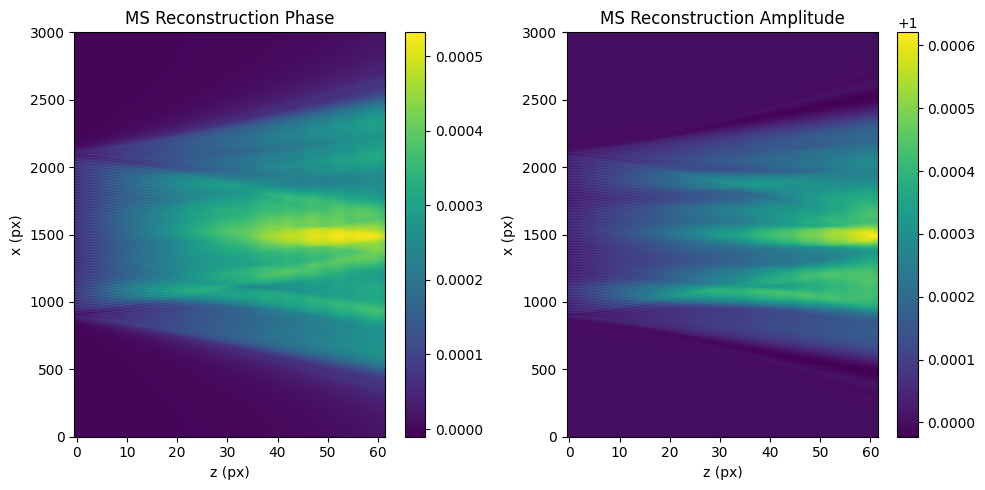

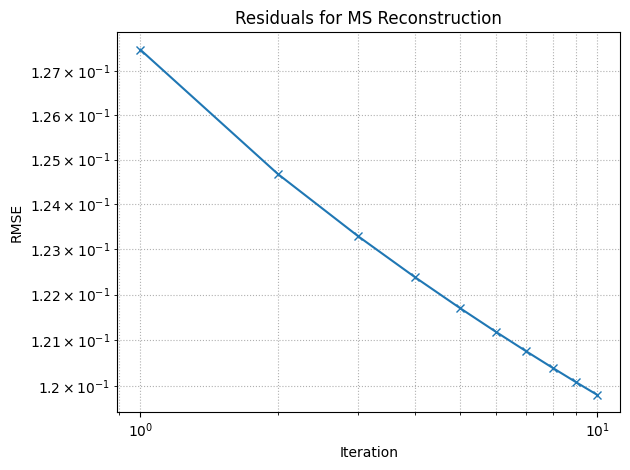

In [5]:
recon_ms = ReconstructorMS(
    simulation_space, data_ew, phase_retrieval=False, verbose=True
)
time_start = time.time()
n_est_ms, residual_ms = recon_ms.reconstruct(max_iters=10, alpha_obj=1e-4)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")

simulation_space.viewer.plot_two_panels(
    n_est_ms,
    view="phase_amp",
    title="MS Reconstruction",
    xlabel="z (px)",
    ylabel="x (px)",
)
simulation_space.viewer.plot_residual(
    residual_ms,
    title="Residuals for MS Reconstruction",
)

2025-12-12 14:54:11,315 - INFO - Initializing Least Squares Solver...
2025-12-12 14:54:11,345 - INFO - Iteration 1/10
2025-12-12 14:54:12,766 - INFO -     RMSE: 0.10257063920208706
2025-12-12 14:54:15,221 - INFO -     Iteration 1 took 3.88 seconds.
2025-12-12 14:54:15,231 - INFO - Iteration 2/10
2025-12-12 14:54:16,444 - INFO -     RMSE: 0.10173499637285419
2025-12-12 14:54:18,843 - INFO -     Iteration 2 took 3.61 seconds.
2025-12-12 14:54:18,867 - INFO - Iteration 3/10
2025-12-12 14:54:20,065 - INFO -     RMSE: 0.10100511711310875
2025-12-12 14:54:22,325 - INFO -     Iteration 3 took 3.46 seconds.
2025-12-12 14:54:22,331 - INFO - Iteration 4/10
2025-12-12 14:54:23,548 - INFO -     RMSE: 0.1003520976887472
2025-12-12 14:54:26,838 - INFO -     Iteration 4 took 4.51 seconds.
2025-12-12 14:54:26,847 - INFO - Iteration 5/10
2025-12-12 14:54:27,912 - INFO -     RMSE: 0.09976796122684038
2025-12-12 14:54:30,234 - INFO -     Iteration 5 took 3.39 seconds.
2025-12-12 14:54:30,244 - INFO - Ite

Reconstruction time: 39.54 seconds


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Residuals for PWE Reconstruction'}, xlabel='Iteration', ylabel='RMSE'>)

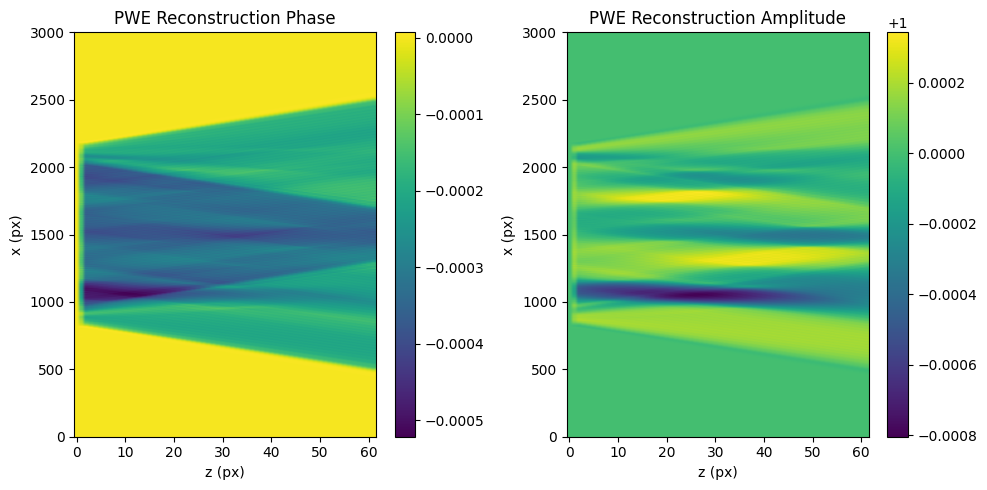

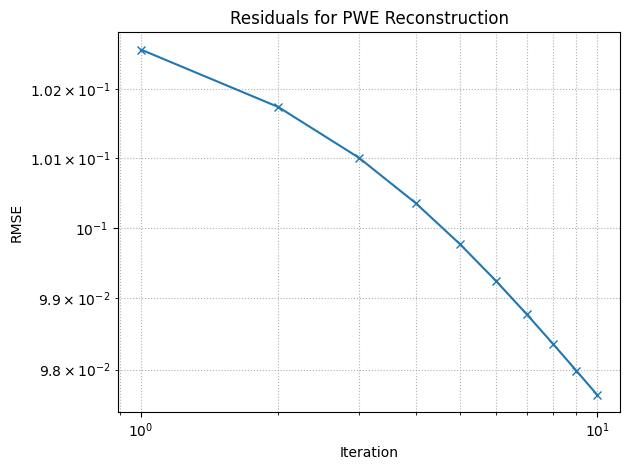

In [6]:
recon_pwe = ReconstructorPWE(
    simulation_space, data_ew, phase_retrieval=False, verbose=True
)
time_start = time.time()
n_est_pwe, recon_u_pwe, residual_pwe = recon_pwe.reconstruct(max_iters=10)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")
simulation_space.viewer.plot_two_panels(
    n_est_pwe,
    view="phase_amp",
    title="PWE Reconstruction",
    xlabel="z (px)",
    ylabel="x (px)",
)
simulation_space.viewer.plot_residual(
    residual_pwe,
    title="Residuals for PWE Reconstruction",
)

## Phase Retrieval

In [ ]:
recon_ms = ReconstructorMS(simulation_space, data, phase_retrieval=True, verbose=True)
time_start = time.time()
n_est_ms, residual_ms = recon_ms.reconstruct(max_iters=20, alpha_obj=1e-4)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")
simulation_space.viewer.plot_two_panels(
    n_est_ms,
    view="phase_amp",
    title="MS Reconstruction with Phase Retrieval",
    xlabel="z (px)",
    ylabel="x (px)",
)
simulation_space.viewer.plot_residual(
    residual_ms,
    title="Residuals for MS Reconstruction with Phase Retrieval",
)

2025-12-12 14:54:51,834 - INFO - Initialized Multislice 3PIE Reconstructor.
2025-12-12 14:54:56,667 - INFO - [Iter 001] Mean Loss = 0.149352, Time = 4.83 seconds
2025-12-12 14:55:00,939 - INFO - [Iter 002] Mean Loss = 0.147499, Time = 4.27 seconds
2025-12-12 14:55:05,434 - INFO - [Iter 003] Mean Loss = 0.146543, Time = 4.49 seconds


In [ ]:
recon_pwe = ReconstructorPWE(simulation_space, data, phase_retrieval=True, verbose=True)
time_start = time.time()
n_est_pwe, recon_u_pwe, residual_pwe = recon_pwe.reconstruct(max_iters=10)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")
simulation_space.viewer.plot_two_panels(
    n_est_pwe,
    view="phase_amp",
    title="PWE Reconstruction with Phase Retrieval",
    xlabel="z (px)",
    ylabel="x (px)",
)
simulation_space.viewer.plot_residual(
    residual_pwe,
    title="Residuals for PWE Reconstruction with Phase Retrieval",
)

# Phase Retrieval (noisy data)

In [ ]:
rng = np.random.default_rng(seed=42)
data_noisy = data.copy() + rng.poisson(np.abs(data))

In [ ]:
recon_ms = ReconstructorMS(
    simulation_space, data_noisy, phase_retrieval=True, verbose=True
)
time_start = time.time()
n_est_ms, residual_ms = recon_ms.reconstruct(max_iters=10, alpha_obj=1e-4)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")
simulation_space.viewer.plot_two_panels(
    n_est_ms,
    view="phase_amp",
    title="MS Reconstruction with Phase Retrieval (Noisy Data)",
    xlabel="z (px)",
    ylabel="x (px)",
)
simulation_space.viewer.plot_residual(
    residual_ms,
    title="Residuals for MS Reconstruction with Phase Retrieval (Noisy Data)",
)

In [ ]:
recon_pwe = ReconstructorPWE(
    simulation_space, data_noisy, phase_retrieval=True, verbose=True
)
time_start = time.time()
n_est_pwe, recon_u_pwe, residual_pwe = recon_pwe.reconstruct(max_iters=10)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")
simulation_space.viewer.plot_two_panels(
    n_est_pwe,
    view="phase_amp",
    title="PWE Reconstruction with Phase Retrieval (Noisy Data)",
    xlabel="z (px)",
    ylabel="x (px)",
)
simulation_space.viewer.plot_residual(
    residual_pwe,
    title="Residuals for PWE Reconstruction with Phase Retrieval (Noisy Data)",
)